In [23]:
# Import libraries
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import warnings
import os
import random

import cv2
from PIL import Image

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler

# Timing utility
from timeit import default_timer as timer
import time
import copy

plt.ion()   # interactive mode

# Setting device on GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cpu


In [24]:
# VGG-16 Takes 224x224 images as input, so we resize all the training and validation data
train_data_path = "data/train"
valid_data_path = "data/validation"
batch_size = 128 # Batch size will depend on the hardware
save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Image transformations. Below are the key steps we take:
# 1. Resize
# 2. Center crop to 224 x 224
# 3. Convert to a tensor
# 4. Normalize with mean and standard deviation
image_transforms = {
    # Train uses data augmentation (Artificially increase the number of training image)
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(), # Randomly change the brightness, contrast and saturation of an image
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [25]:
# Using DataLoaders to avoid loading all of the data into memory at once. 
# First, we create a dataset object from the image folders, and then we pass these to a DataLoader. 
# At training time, the DataLoader will load the images from disk, apply the transformations, and yield a batch. 
# We'll iterate through all the batches in the respective DataLoader.

# Datasets from folders
data = {
    'train': datasets.ImageFolder(root=train_data_path, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_data_path, transform=image_transforms['valid']),
}

# Dataloader iterators with shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True)
}

In [26]:
classes = data['train'].classes
dataset_sizes = {x: len(data[x]) for x in ['train', 'valid']}

print(f"Total classes in the dataset: {classes}")

Total classes in the dataset: ['horses', 'humans']


## Transfer Learning using pre-trained vggnet models
The idea behind pre-training is the early convolutional layers of a cnn extract features that are relevant for many image recognition tasks. The later, fully-connected layers, specialize to the specific dataset by learning higher-level features. Therefore, we can use the already trained convolutional layers while training only the fully-connected layers on our own dataset.

The complete list of models can be found [here](https://pytorch.org/docs/stable/torchvision/models.html)

## VGG16 - Classifier
The classifier is the part of the model that we'll train. However, for the vgg, we'll only need to train the last few layers in the classifier and not even all of the fully connected layers.


## Add on Custom Classifier
We'll train a classifier consisting of the following layers

Fully connected with ReLU activation (n_inputs, 256)
Dropout with 40% chance of dropping
Fully connected with log softmax output (256, n_classes)

To build our custom classifier, we use the nn.Sequential() module which allows us to specify each layer one after the other. We assign our custom classifier to the final classifier layer in the already trained vgg network. When we add on the extra layers, they are set to require_grad=True by default. These will be the only layers that are trained.

In [27]:
def get_model(name="vgg16"):
    # if model_name =="vgg16":
    if True:
        model = models.vgg16(pretrained=True)

        # We freeze all of the existing layers in the network by setting requires_grad to False.
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features
        n_classes = len(classes)
        print("No of inputs: {}".format(n_inputs))
        print("No of classes: {}".format(n_classes))

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), 
            nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, n_classes), 
            nn.LogSoftmax(dim=1))

    return model

In [28]:
model = get_model()
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device="cpu")

No of inputs: 4096
No of classes: 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
   

In [8]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

# The parameters (weights) that will be updated by the optimizer during training
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([2, 256])
torch.Size([2])


In [22]:
def train(model, criterion, optimizer, scheduler, n_epochs=25):
    since = time.time()
    
    # A shallow copy constructs a new compound object and then inserts references into it to the objects found in the original. 
    # A deep copy constructs a new compound object and then, recursively, inserts copies into it of the objects found in the original.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}/{n_epochs-1}')
        print('-'*20)
        
        # Each epoch has training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to validation mode
            
            running_loss = 0.0
            running_corrects = 0.0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Set gradients to 0
                optimizer.zero_grad()
                
                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # Returns values, indices where values is the maximum value of each row of the input tensor
                    loss = criterion(outputs, labels)
                    
                    # Backward + Optimize only if in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elasped = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elasped // 60, time_elasped % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [23]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train(model, criterion, optimizer, exp_lr_scheduler, n_epochs=25)
torch.save(model.state_dict(), 'horse_or_human.pt')


Epoch 0/24
--------------------
train Loss: 0.1498 Acc: 0.9367
valid Loss: 0.0078 Acc: 1.0000

Epoch 1/24
--------------------
train Loss: 0.0055 Acc: 0.9990
valid Loss: 0.0061 Acc: 0.9961

Epoch 2/24
--------------------
train Loss: 0.0030 Acc: 0.9981
valid Loss: 0.0023 Acc: 1.0000

Epoch 3/24
--------------------
train Loss: 0.0067 Acc: 0.9971
valid Loss: 0.0055 Acc: 0.9961

Epoch 4/24
--------------------
train Loss: 0.0082 Acc: 0.9990
valid Loss: 0.0089 Acc: 0.9922

Epoch 5/24
--------------------
train Loss: 0.0070 Acc: 0.9981
valid Loss: 0.0013 Acc: 1.0000

Epoch 6/24
--------------------
train Loss: 0.0064 Acc: 0.9981
valid Loss: 0.0033 Acc: 1.0000

Epoch 7/24
--------------------
train Loss: 0.0073 Acc: 0.9981
valid Loss: 0.0033 Acc: 1.0000

Epoch 8/24
--------------------
train Loss: 0.0006 Acc: 1.0000
valid Loss: 0.0030 Acc: 1.0000

Epoch 9/24
--------------------
train Loss: 0.0011 Acc: 1.0000
valid Loss: 0.0031 Acc: 1.0000

Epoch 10/24
--------------------
train Loss: 0.003

In [31]:
# Loading model from the pt file
model = get_model()
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device="cpu")
model.load_state_dict(torch.load('horse_or_human.pt'))
model.eval()

No of inputs: 4096
No of classes: 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
   

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [32]:
# Test dataset
test_path = 'data/test/'
test_horses_dataset = test_path + 'horses'
test_humans_dataset = test_path + 'humans'

batch_size = 2

transformations = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_dataset = datasets.ImageFolder(root=test_path, transform=transformations)
dataloaders = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [42]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, dataloader, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Make a grid from batch
            out = torchvision.utils.make_grid(inputs.cpu())

            imshow(out, title=[classes[preds[j]] for j in range(inputs.size()[0])])

            images_so_far += inputs.size()[0]
            if images_so_far >= num_images:
                break

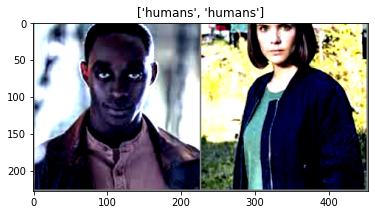

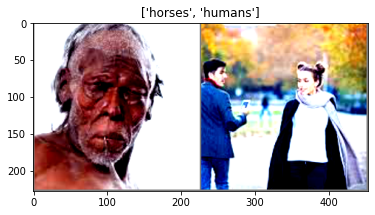

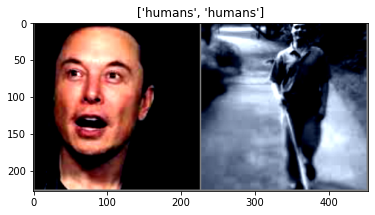

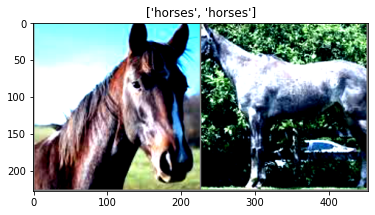

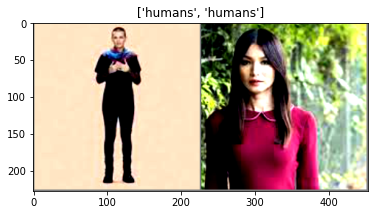

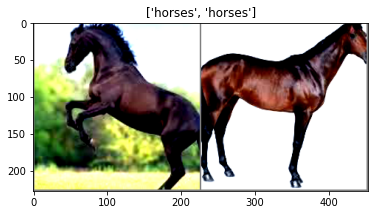

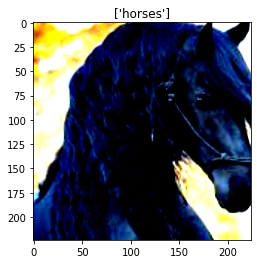

In [43]:
visualize_model(model, dataloaders, num_images=13)

['horses', 'humans']